In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
import pandas as pd
import os
import pickle
import re
import torchaudio.transforms as T
import math
import librosa
import librosa.display
import matplotlib.patches as patches
from glob import glob
import util
from util import audio_file
from util import *
from Losses import FocalLoss,WeightedFocalLoss
from StackedLSTM2 import StackedLSTM
from AttentionLSTM import Attention_LSTM
from Toy_Model import ToyModel
import time
torch.manual_seed(1)

input_list, labels_list = load_data_limit(6)
n_samples = input_list.size()[0]
train_split = 4*n_samples//5
test_samples = n_samples - train_split
test_input_list = input_list[train_split:]
test_labels_list = labels_list[train_split:]
input_list = input_list[:train_split]
labels_list = labels_list[:train_split]
input_list.shape
print("done")

0
(180600,)
1
(180600,)
2
(180600,)
3
(180600,)
4
(180600,)
5
(180600,)
6
done


In [48]:
def load_model(model_path = '/project/graziul/ra/ajays/lang-of-pol/vad/Attention_model/model_weights.pt'):
    model = Attention_LSTM()
    #odel_weights = torch.load(model.state_dict(), model_path)
    model.load_state_dict(torch.load(model_path))
    return model

def convert_to_s(transcritions, frame_length = 25, frame_skip = 10):
    #transcriptions is the frame level transcriptions, to convert to a list of intervals in seconds
    num_frames = np.array(transcriptions).shape[0]
    num_ms = frame_skip*num_frames + frame_length
    ms_seconds_arr = np.zeros(num_frames*frame_length)
    i = 0
    while(1):
        if(i >= num_frames):
            break
        else:
            frame_num = i//frame_skip #lies in this frame for sure
            frame_idx = i - 10*frame_num
            temp = transcriptions[frame_num] + transcriptions[frame_num - 1]
            if frame_idx < 5:
                temp = temp+transcriptions[frame_num - 2]
                
            if temp >= 1:
                ms_seconds_arr[i] = 1
            else:
                ms_seconds_arr[i] = 0
                
    #We have the ms seconds array, now convert to list of intervals
    start = 0
    transcripts_list = []
    start_idx = 0
    end_idx = 0
    for i in range(ms_seconds_arr):
        if(start == 0 and ms_seconds_arr[i] == 1):
            start_idx = i
            start = 1
        else if(start == 1 and ms_seconds_arr[1] == 0):
            end_idx = i-1
            start = 0
            transcripts_list.append([start_idx,end_idx])
    return transcripts_list

class postprocessing():
    def __init__(self, model, inputs_list, labels_list, transcriptions = None):
        self.model = model
        self.inputs_list = inputs_list
        self.true_labels = labels_list
        if self.model:
            self.batch_size = self.model.batch_size
            self.transcriptions = torch.round(get_predictions(self.model, self.inputs_list, self.true_labels, self.batch_size)).numpy()    
        else:
            self.transcriptions = transcriptions
            
    def get_comm_lengths(self):
        #Communication lengths in frames
        final_comms_list = []
        for i in range(self.transcriptions.shape[0]):
            comms_list = []
            start_flag = 0
            end_flag = 0
            run = 0
            for j in range(self.transcriptions.shape[1]):
                if start_flag == 0 and end_flag == 0 and self.transcriptions[i][j] == 1:
                    start_flag = 1
                    run = 1
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 1:
                    run = run +1
                    if j == self.transcriptions.shape[1] - 1:
                            comms_list.append(run)
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 0:
                    comms_list.append(run)
                    start_flag = 0
                    run  = 0
        
            final_comms_list.append(comms_list)
        return final_comms_list
        
    def get_comm_stats(self):
        comms = self.get_comm_lengths()
        for i in range(len(comms)):
            if len(comms[i]) != 0:
                df = pd.DataFrame(np.array(comms[i]))
                print(df.describe())
        comms_combined = sum(comms,[])
        plt.hist(comms_combined, bins = 50)
        return comms_combined
    
    def get_frequencies(self,axis = 1):
        final_freq_list = []
        for i in range(self.transcriptions.shape[0]):
            freq_list = []
            start_flag = 0
            end_flag = 0
            run = 0
            for j in range(self.transcriptions.shape[1]):
                if start_flag == 0 and end_flag == 0 and self.transcriptions[i][j] == 1:
                    start_flag = 1
                    run = 1
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 1:
                    run = run +1
                    if j == self.transcriptions.shape[1] - 1:
                            comms_list.append(run)
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 0:
                    comms_list.append(run)
                    start_flag = 0
                    run  = 0
        
            final_comms_list.append(comms_list)
        return final_comms_list
        

In [ ]:
model = load_model()
post_processor = postprocessing(model, test_input_list, test_labels_list)

180
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1, 4], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [177], [317], [19, 5, 17, 18, 2], [325, 26, 161], [17, 64, 87, 20, 40, 107, 19, 16, 14, 4], [25, 62, 11, 17, 39, 97, 49, 30], [12, 125, 209, 30], [3, 51, 178], [2, 289], [3, 279, 19, 1, 14, 62], [298], [15, 70], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [4], [], [], [], [], [], [], [], [], [], [], [143], [22, 108, 184], [72, 20, 204, 48, 27, 17, 5], [38, 34, 34, 30, 23, 13, 19, 26, 25, 4], [8, 4, 4], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [2, 5], [3], [9, 

               0
count   3.000000
mean   12.000000
std     5.567764
min     6.000000
25%     9.500000
50%    13.000000
75%    15.000000
max    17.000000
           0
count    1.0
mean   306.0
std      NaN
min    306.0
25%    306.0
50%    306.0
75%    306.0
max    306.0
                0
count    6.000000
mean    58.000000
std     67.958811
min      4.000000
25%      7.750000
50%     30.500000
75%     90.000000
max    173.000000
                0
count    4.000000
mean    71.750000
std     42.058491
min     15.000000
25%     58.500000
50%     78.000000
75%     91.250000
max    116.000000
               0
count    4.00000
mean    75.75000
std     96.63807
min      2.00000
25%      3.50000
50%     47.00000
75%    119.25000
max    207.00000
         0
count  1.0
mean   5.0
std    NaN
min    5.0
25%    5.0
50%    5.0
75%    5.0
max    5.0
                0
count    3.000000
mean    71.666667
std    118.950970
min      1.000000
25%      3.000000
50%      5.000000
75%    107.000000
max    209

None


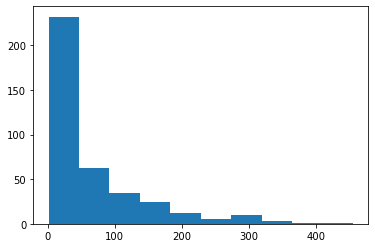

In [42]:
print(post_processor.transcriptions)
print(post_processor.get_comm_lengths())
print(post_processor.get_comm_stats())

In [47]:
print(np.array(test_labels_list[31]))
print(post_processor.transcriptions[31])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [45]:
pkl_path = '/project/graziul/ra/ajays/whitelisted_vad_dict.pkl'
file = open(pkl_path,'rb')
vad_dict = pickle.load(file)
file.close()

for idx,key in enumerate(vad_dict):
        print(idx)
        if idx > 0:
            break
        a = audio_file(key)
        a.get_slices(vad_dict)
        a.get_split_frames()

0


AttributeError: 'audio_file' object has no attribute 'sample_rate'